In [1]:
!sudo pip uninstall -y pydot

The directory '/Users/rlx/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
DEPRECATION: Uninstalling a distutils installed project (pydot) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
Uninstalling pydot-1.0.28:
  Successfully uninstalled pydot-1.0.28
The directory '/Users/rlx/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Convolutional networks on MNIST

code from from [here](http://ml4a.github.io/guides/convolutional_neural_networks) and [here](https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb). see [filter activation demo](http://ml4a.github.io/dev/demos/demo_convolution.html)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import theano
%matplotlib inline

from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


Using Theano backend.
/opt/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [3]:
mnist = np.loadtxt("data/mnist1.5k.csv", delimiter=",")
height, width = 28, 28
# we have a 28x28 single channel (grayscale) image so each image shape is (1, 28, 28
X=mnist[:,1:785].reshape(len(mnist), 1, height, width)
y=mnist[:,0]
ntr = 1000
X_train, y_train = X[:ntr], y[:ntr]
X_test,  y_test  = X[ntr:], y[ntr:]

# normalize from [0, 255] to [0, 1]
X_train /= 255
X_test /= 255

# numbers 0-9, so ten classes
n_classes = 10

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [4]:
# number of convolutional filters
n_filters = 32

# convolution filter size, i.e. we will use a n_conv x n_conv filter
n_conv = 3

# pooling window size, i.e. we will use a n_pool x n_pool pooling window
n_pool = 2

### build the network 

In [5]:
model = Sequential()
model.add(Convolution2D( n_filters, 
                        n_conv, n_conv, 
                        border_mode='valid', 
                        input_shape=(1, height, width)
))

activation1 = Activation('relu')
model.add(activation1)

model.add(Convolution2D(n_filters, n_conv, n_conv))
a1 = Activation('relu')
model.add(Activation('relu'))

# then we apply pooling to summarize the features
# extracted thus far
model.add(MaxPooling2D(pool_size=(n_pool, n_pool)))
model.add(Dropout(0.25))
# flatten the data for the 1D layers
model.add(Flatten())
# Dense(n_outputs)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# the softmax output layer gives us a probablity for each class
model.add(Dense(n_classes))
model.add(Activation('softmax'))

### compile it

In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam')

### train it 
(try more epochs, 30secs to 1min per epoch aprox)

In [7]:
# how many examples to look at during each training iteration
batch_size = 128

# how many times to run through the full set of examples
n_epochs = 1

# the training may be slow depending on your computer
model.fit(X_train, y_train,
          batch_size=batch_size,
          nb_epoch=n_epochs,
          validation_data=(X_test, y_test))

Train on 1000 samples, validate on 500 samples
Epoch 1/1
1000/1000 [==============================] - 42s - loss: 1.8885 - val_loss: 1.0290


### measure performance on test data

In [8]:
p = model.predict_classes(X_test)
pc = to_categorical(p)
acc = [np.allclose(pc[i],y_test[i]) for i in range(len(y_test))]
np.sum(acc)*1./len(acc)

500/500 [==============================] - 3s     


0.78000000000000003

### See first layer filters

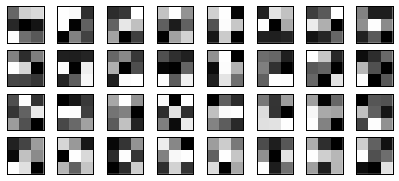

In [9]:
w1 = model.get_weights()[0]
plt.figure(figsize=(7,3))
for i in range(w1.shape[0]):
    plt.subplot(4,8,i+1)
    plt.imshow(w1[i,0,:,:], cmap=plt.cm.binary, interpolation="none")
    plt.xticks([]); plt.yticks([]);

In [10]:
X_test[:1].shape

(1, 1, 28, 28)

In [11]:
p = model.predict_classes(X_test[:2])
t = model.get_params()[0][1]
t.get_value()

2/2 [==============================] - 0s


array([  1.43583526e-03,  -3.62878782e-03,  -1.47883291e-03,
        -2.45223101e-03,  -1.95557903e-03,  -3.09417560e-03,
        -4.61680960e-04,  -3.42218066e-03,  -4.50446550e-03,
        -1.87936064e-03,  -3.29814735e-03,  -2.10948172e-03,
        -3.35667911e-03,  -5.78970322e-03,   1.52660883e-04,
        -2.16457574e-03,  -5.28881047e-03,  -1.82934524e-03,
        -1.82536349e-03,   3.13468371e-03,  -4.65797167e-03,
         3.45505076e-03,  -4.38403944e-03,  -7.02879333e-04,
         1.16103503e-03,  -7.34478381e-05,  -1.92701421e-03,
        -3.97397997e-03,  -2.91567645e-03,  -1.46300206e-03,
        -1.89655414e-03,  -3.91531503e-03], dtype=float32)

In [12]:
convout1_f = theano.function([model.get_input(train=False)], activation1.get_output(train=False))


In [13]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

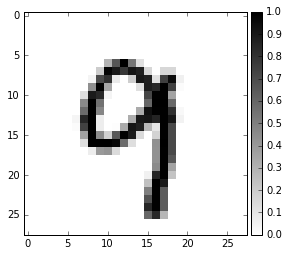

In [27]:
# Visualize the first layer of convolutions on an input image
img_idx = np.random.randint(len(X_test))
img = X_test[img_idx,0]
plt.figure()
nice_imshow(plt.gca(), img, vmin=0, vmax=1, cmap=plt.cm.binary)

In [28]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


(32, 26, 26)


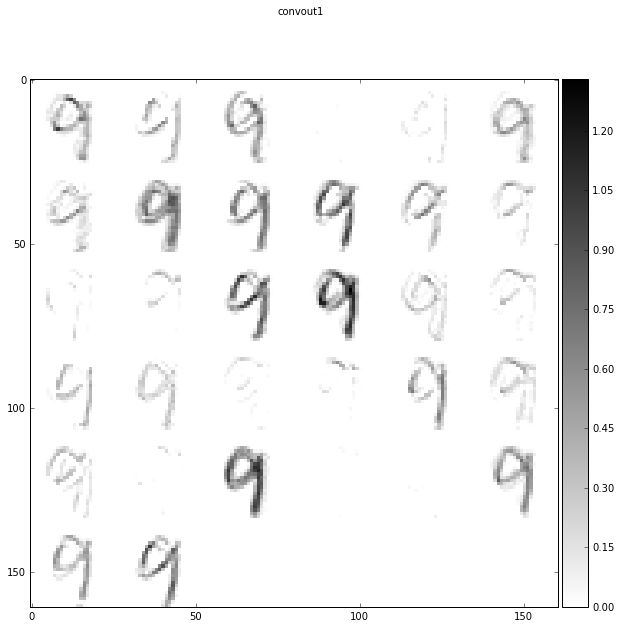

In [29]:
C1 = convout1_f(X_test[img_idx:img_idx+1].astype(np.float32))[0]
print C1.shape
plt.figure(figsize=(10, 10))
plt.suptitle('convout1')
nice_imshow(plt.gca(), make_mosaic(C1, 6, 6), cmap=plt.cm.binary)